In [14]:
import torch as t
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch.nn.functional as F
from datetime import datetime
from torch.autograd import Variable
from torchvision.utils import save_image
import imageio
import os
import math

https://medium.com/datadl-ai/mnist-exploration-to-execution-25136ca00570
Following this tutorial

First stap is to get the dataset, this is the MNIST dataset wich is a dataset that has images of numbers 0 - 9.

In [15]:
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

train_data = tv.datasets.MNIST("data/train",train=True, download=True, transform = transform)
test_data = tv.datasets.MNIST("data/test",train=False,download=True,transform=transform)

# kwargs = {'num_workers': 10, 'pin_memory': True} # GPU
kwargs = {'num_workers': 1, 'pin_memory': False} # CPU

train_loader = t.utils.data.DataLoader(train_data,batch_size=32,shuffle=True,**kwargs)
test_loader = t.utils.data.DataLoader(test_data,batch_size=32,shuffle=True,**kwargs)

In [16]:
sampleX,sampleY = iter(train_loader).__next__()
print("The sample data shape is ",sampleX.shape,sampleY.shape)

The sample data shape is  torch.Size([32, 1, 28, 28]) torch.Size([32])


<h1>Data visualisation</h1>

To see what the data look like

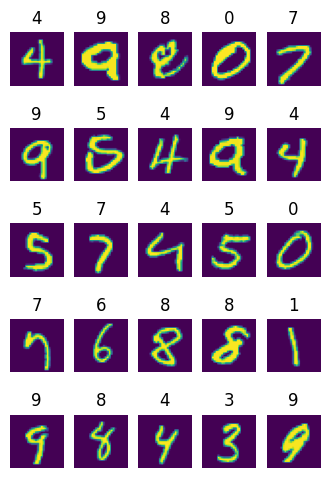

In [17]:
figure = plt.figure(figsize=(4,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis("off")
    plt.title(sampleY.numpy()[i])
    plt.imshow(sampleX.numpy()[i].squeeze())

In [20]:
use_cuda = t.cuda.is_available()
device = t.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

Because handwriting is very different per person, finding the mean of the images per valua can show us if the data set is clean

(60000, 1, 28, 28) (60000,)


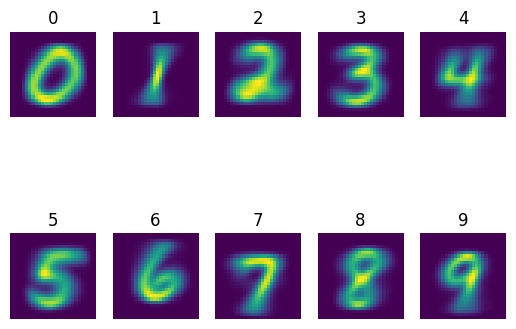

In [22]:
explore_X,explore_y = [],[]
for i in range(len(train_loader)):
    
    X,y = iter(train_loader).__next__()    
    explore_X.append(X.numpy())
    explore_y.append(y.numpy())
    
explore_X,explore_y = np.array(explore_X).reshape([60000,1,28,28]),np.array(explore_y).reshape([1875*32])
print(explore_X.shape,explore_y.shape)

def get_class_arrays(class_index):
    return explore_X[explore_y==class_index],explore_y[explore_y==class_index]

def get_mean_images():
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_image = class_arrayX.mean(axis=0)
        plt.subplot(2,5,i+1)
        plt.axis("off")
        plt.title(i)
        plt.imshow(mean_image.squeeze())
        
get_mean_images()

All the images are made up of black and white pixels, so here it becomes clear how much per value there are, this can be something we can train the model on if it is very different from each other

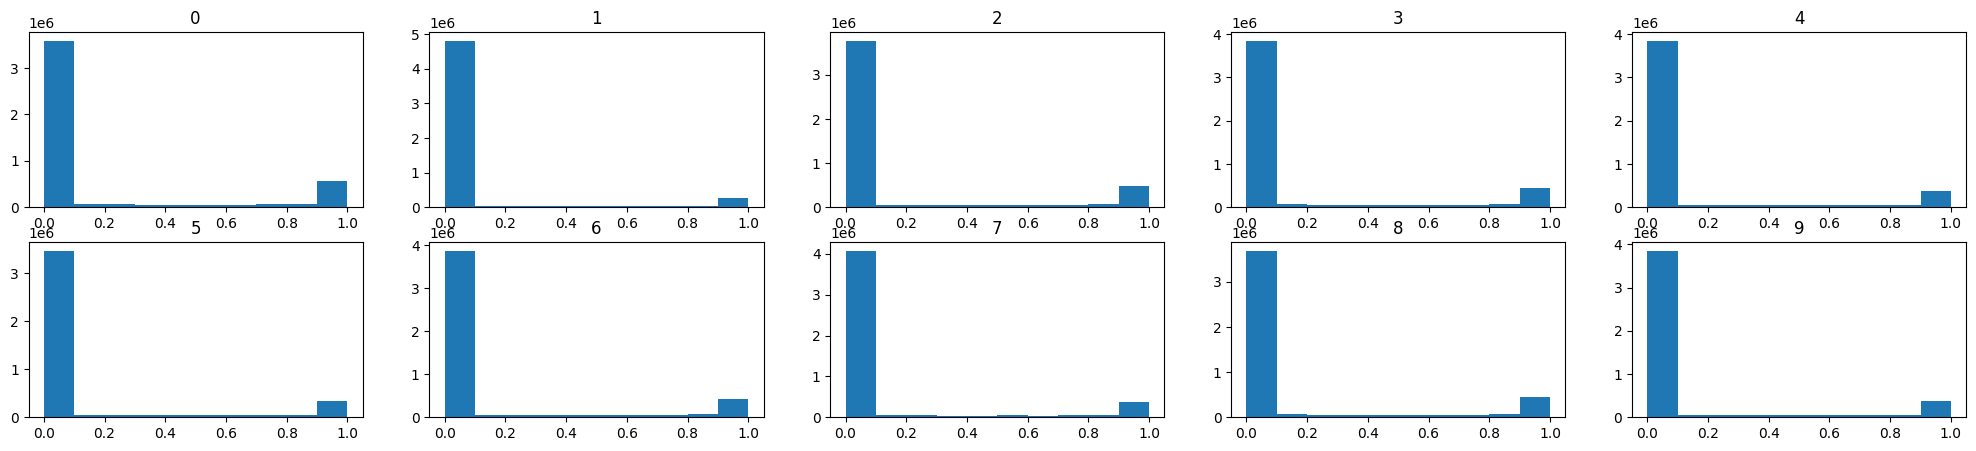

In [23]:
def get_class_arrays(class_index):
    return explore_X[explore_y==class_index],explore_y[explore_y==class_index] 
figure = plt.figure(figsize=(25,5))

def get_histogram():
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        plt.subplot(2,5,i+1)
        _ = plt.hist(class_arrayX.reshape(-1))
        plt.title(i)
get_histogram()

In thas you see most pixels values are ZERO(black), some are ONE(white), few between 0 and 1 for all the classes.

if we plot the mean images distribution,here it looks like class 1 takes the least number of white pixels, this makes sense because the one is only 1 line.

[0.1733845, 0.076001436, 0.1485642, 0.14135875, 0.12157102, 0.12916896, 0.13706174, 0.11403547, 0.15030146, 0.122193165]


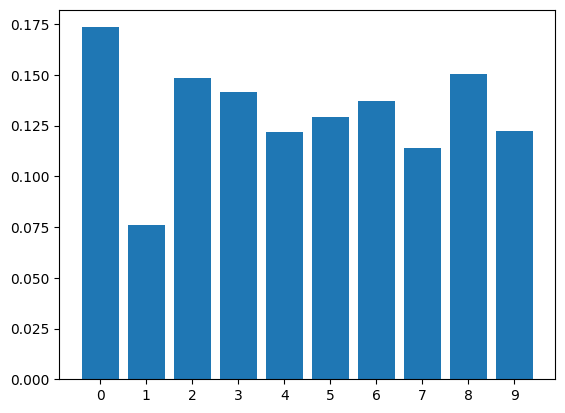

In [24]:
def get_mean_barchart():
    mean_values =[]
    for i in range(10):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_values.append(class_arrayX.mean())
    
    plt.bar(np.arange(10),mean_values, align='center')
    plt.xticks(np.arange(10))
    print(mean_values)

get_mean_barchart()

The whole point of dimensional reduction techniques is to convert the high dimensional data to low dimensional data effectively (without loosing too much information of the data)

they are good for data visualization , feature selection and engineering.

here input X has 28*28 pixels (784- dimensional vector) so we are going to apply PCA.

it’s a linear dimensional reduction technique which captures the most variance features (2 or 3 out of 784)

<h3>What is PCA</h3>
Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize, and thus make analyzing data points much easier and faster for machine learning algorithms without extraneous variables to process.

So, to sum up, the idea of PCA is simple: reduce the number of variables of a data set, while preserving as much information as possible.

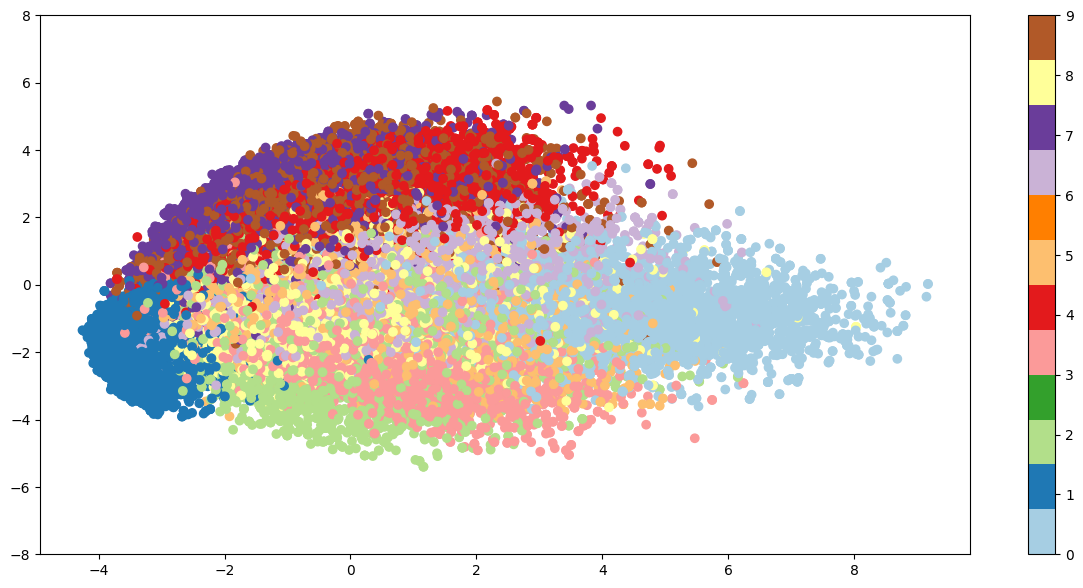

In [25]:
figure = plt.figure(figsize=(15,7))

pca = PCA(n_components=2)
proj = pca.fit_transform(explore_X.reshape(-1,784))
plt.scatter(proj[:, 0], proj[:, 1], c=explore_y, cmap="Paired")
plt.ylim([-8,8])
plt.colorbar(ticks=range(10))

as you can see here, the data/classes have been split into 10 different clusters/groups.

while we can see, the visualization looks good even with just 2 dimensions, its not enough to separate the classes so luckily we have another techniques called t-SNE which is a non linear dimensional reduction technique and a probabilistic approach unlike PCA which is a mathematical approach.

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE
embeddings = TSNE(n_jobs=2).fit_transform(explore_X.reshape(-1,784))

C:\Users\Nick\AppData\Local\Temp\ipykernel_9816\3519670481.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(embeddings[:, 0], embeddings[:, 1], c=explore_y, cmap=plt.cm.get_cmap("jet", 10), marker='.')


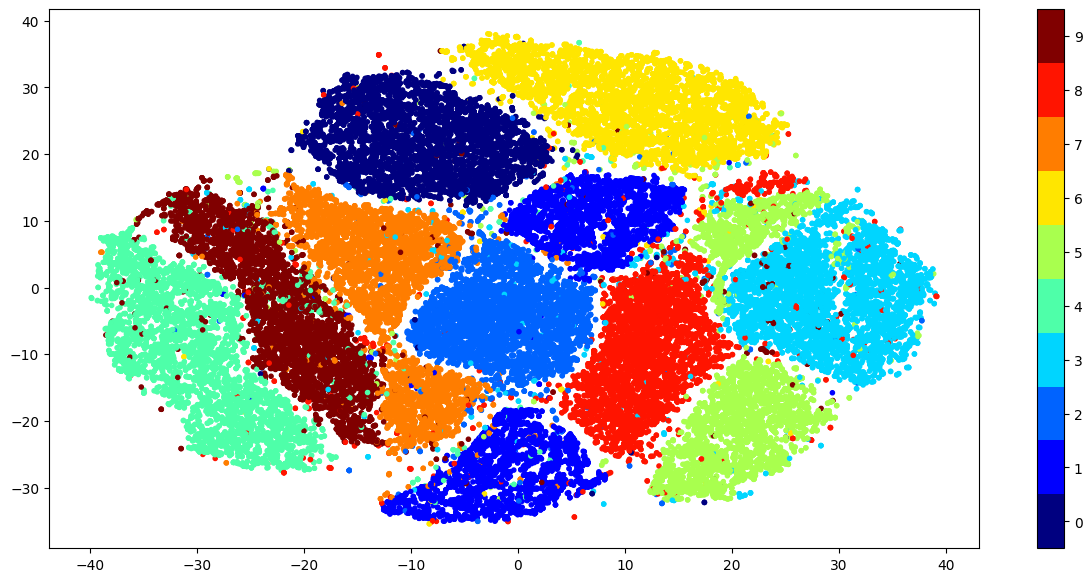

In [34]:
figure = plt.figure(figsize=(15,7))

plt.scatter(embeddings[:, 0], embeddings[:, 1], c=explore_y, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

t-SNE requires a lot of computation thus it takes a lot of time (minutes to hours) compared to PCA (secs to minutes) so here I used Multicore TSNE which took around 10–15 mins over scikit learn t-SNE which seemed taking tons of time.

here we can clearly see the classes have been split well.

Now we can do each class seperate

In [35]:
def get_class_embeddings_arrays(class_index):
    return embeddings[explore_y==class_index],explore_y[explore_y==class_index]

C:\Users\Nick\AppData\Local\Temp\ipykernel_9816\32661227.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("jet", 10), marker='.')


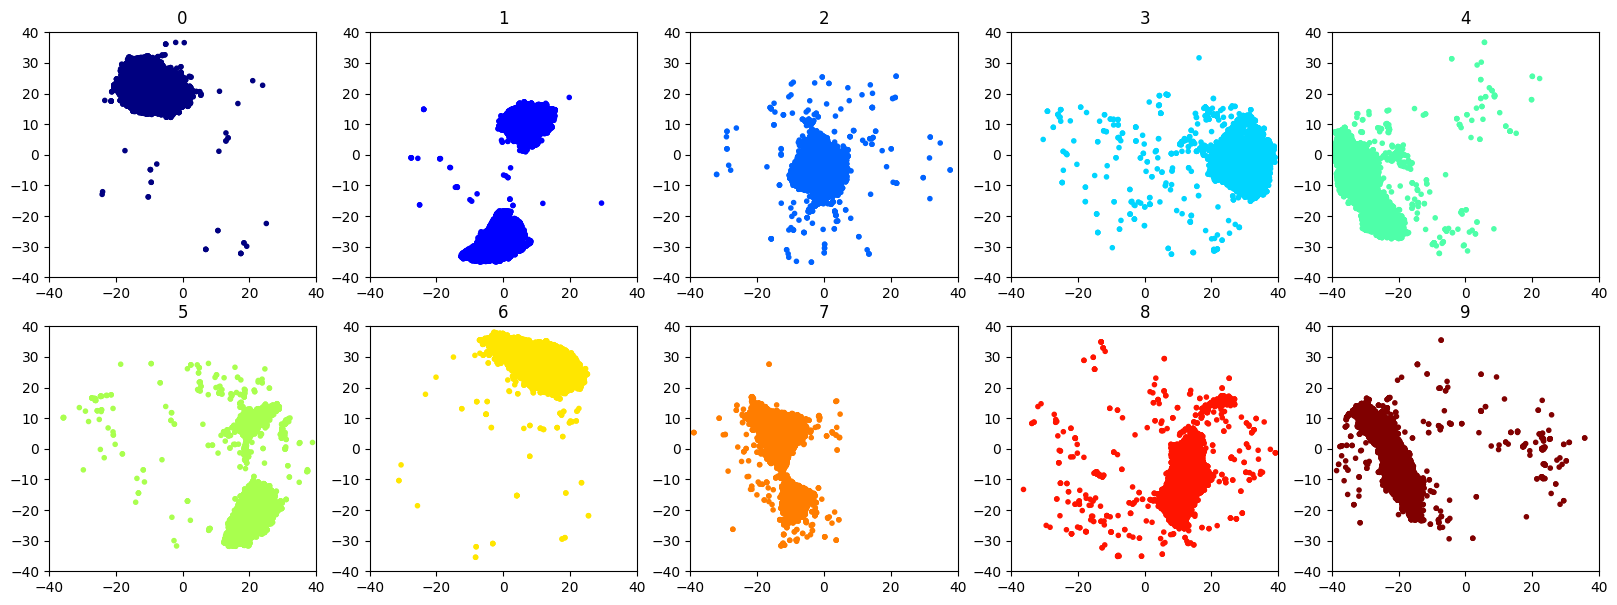

In [36]:
figure = plt.figure(figsize=(20,7))

for i in range(10):
    plt.subplot(2,5,i+1)
    class_embeddings_arrayX,class_embeddings_arrayY = get_class_embeddings_arrays(i)
    plt.scatter(class_embeddings_arrayX[:, 0], class_embeddings_arrayX[:, 1], c=class_embeddings_arrayY, 
                cmap=plt.cm.get_cmap("jet", 10), marker='.')
    plt.clim(-0.5, 9.5)
    plt.axis([-40, 40, -40, 40])
    plt.title(i)

Now we can see cleary that classes 3 & 8 are more spread out and 0,1 & 6 look pretty good.

<h1>Training the model</h1>

The data looks clean so now we can focus on training a model, for image recognision CNN (Convolutional neural network) works well so I'm going to try that.

In [38]:
class FirstModel(t.nn.Module):
    
    def __init__(self):
        super(FirstModel,self).__init__()
        self.conv1 = t.nn.Conv2d(1,32,3,1)
        self.fc1 = t.nn.Linear(32*26*26,128)
        self.fc2 = t.nn.Linear(128,10)
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = x.view(-1,32*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

first_model = FirstModel().to(device)

In [52]:
epochs = 10
learning_rate = 1e-2
momentum = 0.5

criterion = t.nn.CrossEntropyLoss()
optimizer = t.optim.SGD(first_model.parameters(),lr=learning_rate,momentum=momentum)

I just took a 2 layer network (Conv+FC) and Lr = 0.01 and momentum = 0.5 (generally this learning rate works well )

In [53]:
def book_keeping(epoch,time,model):
    train_correct_predictions = 0
    test_correct_predictions = 0
    train_epoch_loss = 0
    test_epoch_loss = 0

    for batchX,batchY in iter(train_loader):
        
        batchX, batchY = batchX.to(device), batchY.to(device)
        
        outputs = model(batchX)
        loss = criterion(outputs,batchY)
        train_epoch_loss += loss.item()

        predictions = t.argmax(outputs.data, 1)
        train_correct_predictions+= (predictions == batchY).sum().item()
        
    for batchX,batchY in iter(test_loader):
        batchX, batchY = batchX.to(device), batchY.to(device)

        outputs = model(batchX)
        loss = criterion(outputs,batchY)
        test_epoch_loss += loss.item()
        
        predictions = t.argmax(outputs.data, 1)
        test_correct_predictions+= (predictions == batchY).sum().item()
    
    train_acc = (train_correct_predictions / (len(train_loader)*32)) * 100
    test_acc = (test_correct_predictions / (len(test_loader)*32)) * 100
    
    print('Epoch = {}, Time = {}, Train Loss: {:.2f}, Test Loss: {:.2f}, Train Accuracy: {:.2f}%,Test Accuracy: {:.2f}%'.format(epoch + 1, time, train_epoch_loss,test_epoch_loss,train_acc,test_acc))
    
    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

In [54]:
train_losses,test_losses,train_accs,test_accs = [],[],[],[]

In [55]:
def train(model):
    
    for i in range(10):
        start = datetime.now()

        for batchX,batchY in iter(train_loader):

            batchX, batchY = batchX.to(device), batchY.to(device)

            optimizer.zero_grad()
            outputs = model(batchX)

            loss = criterion(outputs,batchY)

            loss.backward()
            optimizer.step()

        end = datetime.now()
        time = (end-start).total_seconds()
        book_keeping(i,time,model)

train(first_model)

Epoch = 1, Time = 23.577089, Train Loss: 75.31, Test Loss: 20.84, Train Accuracy: 98.73%,Test Accuracy: 97.90%
Epoch = 2, Time = 23.240174, Train Loss: 67.30, Test Loss: 21.01, Train Accuracy: 98.93%,Test Accuracy: 97.77%
Epoch = 3, Time = 23.4271, Train Loss: 67.70, Test Loss: 21.28, Train Accuracy: 98.91%,Test Accuracy: 97.78%
Epoch = 4, Time = 24.262462, Train Loss: 65.34, Test Loss: 22.47, Train Accuracy: 98.89%,Test Accuracy: 97.79%
Epoch = 5, Time = 32.903152, Train Loss: 40.85, Test Loss: 19.67, Train Accuracy: 99.37%,Test Accuracy: 97.83%
Epoch = 6, Time = 34.576582, Train Loss: 41.58, Test Loss: 18.40, Train Accuracy: 99.32%,Test Accuracy: 98.04%
Epoch = 7, Time = 23.103095, Train Loss: 38.49, Test Loss: 20.45, Train Accuracy: 99.39%,Test Accuracy: 97.84%
Epoch = 8, Time = 23.777653, Train Loss: 26.68, Test Loss: 18.41, Train Accuracy: 99.62%,Test Accuracy: 98.11%
Epoch = 9, Time = 23.864302, Train Loss: 38.24, Test Loss: 22.23, Train Accuracy: 99.34%,Test Accuracy: 97.88%
Epo

As you can see , after 10 epochs the train accuracy reaches 99% because the data is pretty easy for the model to generalize/separate classes

d